# Solutions Week 10: Simulating stochasticity in gene expression

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025


In today's exercise session, we will simulate the chemical master equation (CME) of two processes using the Gillespie algorithm.  

* In *Exercise 1*, you will consider a simple birth-death process and study its properties.  
  
* In *Exercise 2*, you will simulate a chemical oscillator known as the *Brusselator*

In [1]:
#import librairies

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.integrate import odeint

# Exercise 1: Probabilistic description of the Birth-death process
Let's consider a simple birth-death process in which molecules are produced at a rate $s$ (probability of producing a new molecule per unit of time) and degraded at a rate $k$.  

The four possible reactions can be described as follow:
$$
\begin{array}{lll}
n-1 & \longrightarrow n & \text{with rate } s \\
n & \longrightarrow n+1 & \text{with rate } s \\
n+1 & \longrightarrow n  & \text{with rate } k(n+1) \\
n & \longrightarrow n-1 & \text{with rate } kn
\end{array}
$$

From those, we can describe the master equation which gives the probability $P(n,t)$ to have $n$ molecules of the compound at time $t$:  

$$
\frac{dP(n,t)}{dt} = sP(n-1,t) + k(n+1)P(n+1,t) - (s + kn)P(n,t)
$$


### Question 1
Simulate the birth-death process using the code for the Gillespie algorithm provided below.  

1. Study the provided code. Identify and describe the sequence of steps the algorithm uses to simulate the birth-death process. Explain how it selects the time for the next reaction and determines which reaction will occur.  

2. Inspect the code for sections marked with 'FILL HERE'. Complete these sections with the appropriate code to fulfill the algorithm's requirements.  

3. Execute the completed Gillespie simulation of the birth-death process multiple times. Describe the behavior of the molecule counts over time.

4. Using the results from your simulations and the code below, verify that the steady-state distribution of the molecule count $n$ follows a Poisson distribution. You can do this by comparing the empirical distribution from the simulation to the theoretical Poisson distribution with parameter $\lambda$. 

5. Investigate how the synthesis rate $s$ and degradation rate $k$ influence the steady-state distribution. Discuss how varying these parameters alters the shape and parameters of the Poisson distribution?

### Answer 1
**1.**  
<ol type="a">
<li>Initialization: Start with an initial state of the system.</li>
<li>Time Step Selection: Randomly pick the time until the next reaction occurs, using an exponential distribution with the rate parameter equal to the sum of all reaction rates.</li>
<li>Reaction Selection: Randomly select which specific reaction will occur next, with probabilities proportional to their individual rates.</li>
<li>State Update: Apply the chosen reaction to update the system's state.</li>
<li>Iteration: Repeat steps b to d until reaching a desired endpoint or time limit.</li>
</ol>

**2.** See code below. 

**3.** In one simulation run, you'll observe a sequence of births and deaths over time. The molecule count may increase and decrease in a stochastic manner. If you run the Gillespie simulation multiple times, you'll get different trajectories for molecule counts in each run due to the inherent randomness in the process.  

**4.** In a Poisson distribution, the mean and variance of $n$ should closely match $\lambda$. You can set $\lambda$ to the predicted mean number of molecules at steady-state.

**5.** $\lambda$ is calculated as $\lambda = \frac{s}{k}$.



#### Gillespie algorithm for the birth-death process:

In [21]:
def simulate_birth_death_process(s, k, total_time, n_0=0, t_0=0, return_even=False):
    """
    Simulate the birth-death process using the Gillespie algorithm.

    Parameters:
    s: The rate at which new molecules are produced [molecules per unit time].
    k: The degration rate [hr^-1].
    total_time: Total simulation time [hr] (should be choosen according to the half-life time).
    n_0: Initial number of molecules.
    t_0: Initial time.
    return_even: If True report the state of the system at evenly spaced time intervals DT, else report the state of the system each time a new reaction takes place.

    Returns:
    n: The number of molecules at each time step.
    t: The time at each time step.
    if return_even is True:
    n_print: The number of molecules at each observation step
    t_print: The time of each observation step
    """

    # Initialize molecule count and time lists
    n = [n_0] # Initial number of molecules
    t = [t_0]  # Initial time
    DT=0.01
    n_print=[]
    t_print=[]
    # Run the simulation until the end time is reached
    tp=t_0
    while t[-1] < total_time:
        current_n = n[-1]
        
        # Define the rates for production and degradation
        rates = [s, k * current_n] # FILL HERE
        
        # Calculate the total rate
        rates_tot = sum(rates)
        
        # Pick the next time interval using an exponential distribution
        dt = np.random.exponential(scale=1/rates_tot) # scale is 1/lambda
        t.append(t[-1] + dt)

        #This is to report the state of the system at evenly spaced time intervals DT, 
        #while the actual reaction times are not evenly spaced. This is useful when histograms are needed. 
        while tp < t[-1] and t[-1] <= total_time:
            n_print.append(n[-1])
            t_print.append(tp)
            tp += DT
        
        # Generate a random number to decide the next event
        rand_uniform = np.random.random()
        
        # Determine whether a birth or death event occurs
        if rand_uniform <= (rates[0] / rates_tot):
            n.append(current_n + 1)  # Birth event, FILL HERE
        else:
            n.append(current_n - 1)  # Death event, FILL HERE

    if return_even:
        return n_print, t_print
    else:
        return n, t

def plot_simulation_results(t, n, transient_cutoff, poisson_lambda):
    """
    Plot the results of the birth-death process simulation and compare with Poisson distribution.

    Parameters:
    t: The time points of the simulation.
    n: The number of molecules at each time point.
    transient_cutoff: The number of initial time points to exclude from histogram.
    poisson_lambda: The lambda parameter for the Poisson distribution.
    """
    
    # Plot the time evolution of molecule count
    plt.figure(figsize=(15, 5))
    plt.plot(t, n)
    plt.xlabel("time [hr]")
    plt.ylabel("n molecules")
    plt.title("Time Evolution of Molecule Count")
    plt.show()   

    # Plot the histogram after removing transient
    plt.hist(n[transient_cutoff:], bins=100, label='nb. occurrence')
    ntot = len(n[transient_cutoff:])
    
    # Generate Poisson distributed samples
    nn = np.arange(max(n[transient_cutoff:])*1.2)
    p = poisson.pmf(nn, poisson_lambda)
    p = p * ntot  # Scale by the total number of observations
    
    # Plot the Poisson distribution
    plt.plot(nn, p, label='Poisson(lambda)*ntot')
    plt.xlabel("n molecules")
    plt.ylabel("Probability")
    plt.title("Histogram of Molecule Count with Poisson Distribution")
    
    plt.legend()
    plt.show()

#### Run the simulation

In [22]:
# Parameters for the simulation
s = 20  # Synthesis rate in molecules per unit time
k = 1  # Degradation rate in hr^-1
total_time = 200  # Total simulation time in hours

# Run the simulation
molecule_count, time_points = simulate_birth_death_process(s, k, total_time)

#### Plot the trajectory and histogram

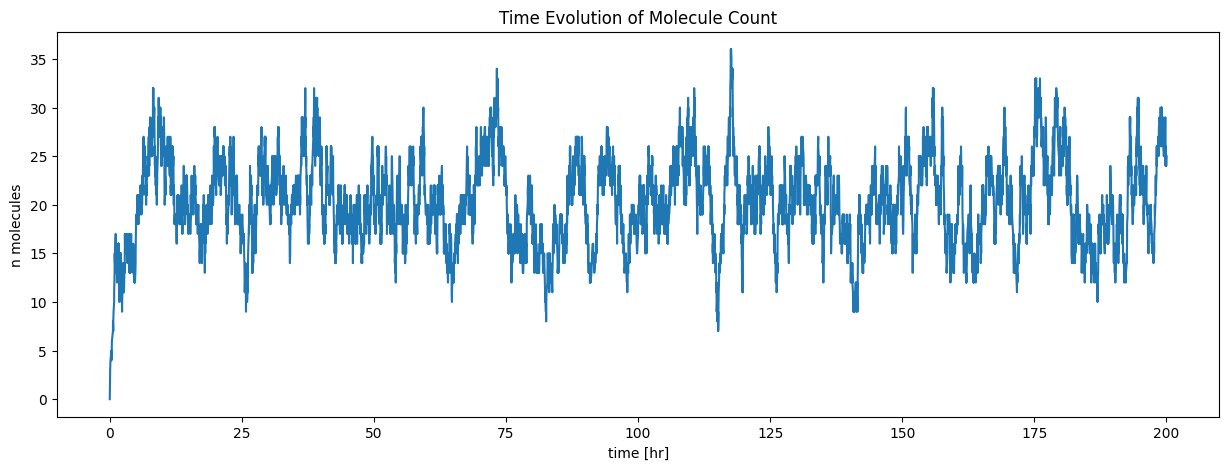

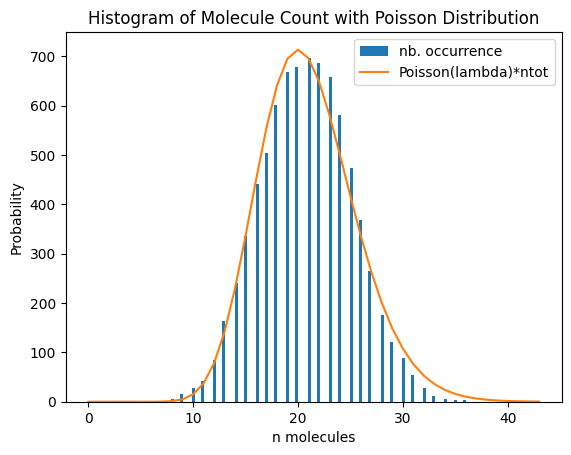

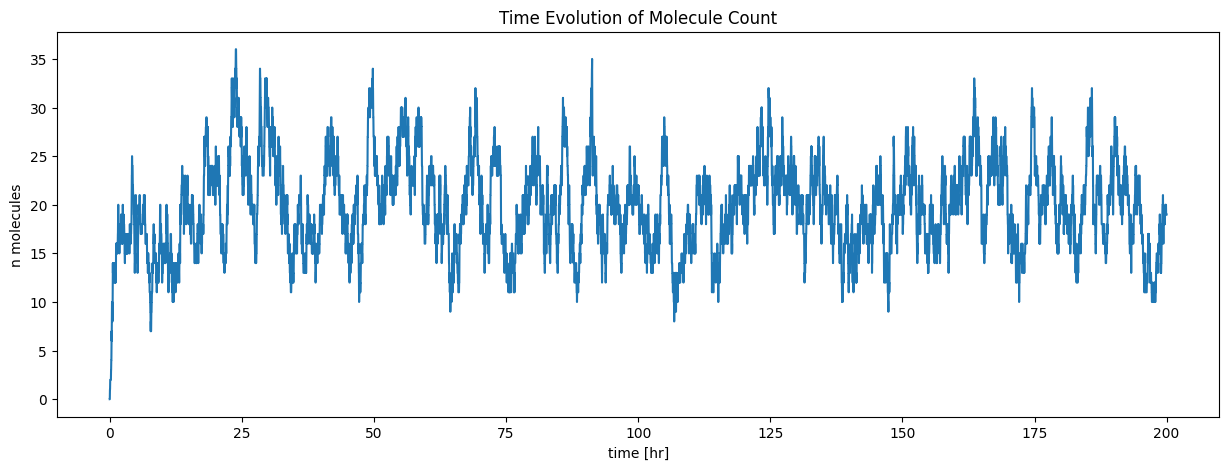

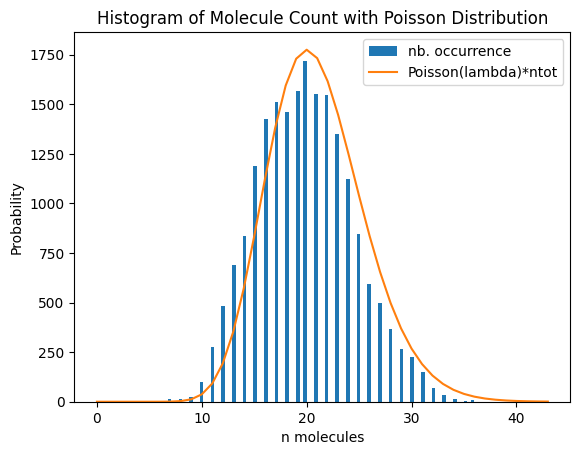

In [23]:
# Parameters for plotting
transient_cutoff = 20  # Adjust as needed to remove the transient part for the histogramm
poisson_lambda = s/k    # Change lambda to fit the histogram

# Call the plotting function with simulation results and parameters
plot_simulation_results(time_points, molecule_count, transient_cutoff, poisson_lambda)

#Plot for evenly spaced time intervals
molecule_count, time_points = simulate_birth_death_process(s, k, total_time, return_even=True)
plot_simulation_results(time_points, molecule_count, transient_cutoff, poisson_lambda)


# Exercise 2: The Brusselator

The Brusselator (proposed in 1967 in Brussels by R. Lefever I. Prigogine et G. Nicolis) describes a chemical oscillator governed by the following chemical reactions:

$$
\begin{array}{|c|c|c|c|}
\hline
\text{Reaction} & \text{Reaction Rate} & \frac{dX}{dt} & \frac{dY}{dt} \\
\hline
\emptyset \xrightarrow{k_1} X & v_1 = k_1 & +v_1 & 0 \\
X \xrightarrow{k_2} Y & v_2 = k_2 X & -v_2 & +v_2 \\
2X + Y \xrightarrow{k_3} 3X & v_3 = k_3 X^2 Y & +v_3 & -v_3 \\
X \xrightarrow{k_4} \emptyset & v_4 = k_4 X & -v_4 & 0 \\
\hline
\end{array}
$$



The determinisitic equations for the concentrations $X$ and $Y$ are given by:

$$
\begin{align*}
\frac{dX}{dt} &= k_1 - k_2X + k_3X^2Y - k_4X \\
\frac{dY}{dt} &= k_2X - k_3X^2Y
\end{align*}
$$


In the stochastic description of this process, we have to associate to each reaction a transition probability (with $n$ and $m$, the number of molecules  of $X$ and $Y$, respectively):

$$
\begin{array}{|c|c|}
\hline
\text{Reaction} & \text{Transition Rate} \\
\hline
n \rightarrow n + 1 & r_1 = k_1 \Omega \\
n \rightarrow m & r_2 = k_2 n \\
2n + m \rightarrow 3n & r_3 = k_3 n(n-1)m \Omega^{-2} \\
n \rightarrow n - 1 & r_4 = k_4 n \\
\hline
\end{array}
$$


In stochastic chemical kinetics, the system size $\Omega$ represents the volume of the system. It is crucial for converting deterministic rate constants, which are typically given in concentrations per unit time, into stochastic transition rates, which are probabilities per unit time. For example, the rate constant $k_1$ has units of concentration over time. In a stochastic description, we are not dealing with concentrations but with the probabilities of individual reactions occurring in a system of size $\Omega$. To convert this rate constant into a transition rate, we multiply by $\Omega$  to adjust for the volume of the system. This ensures that $r_1$ has the correct units of 1/time, representing the probability per unit time of one more molecule appearing due to the reaction.

### Question 1
1. Below is a Python code snippet that simulates the Brusselator system using ODE. Your task is to fill in the missing parts where you see 'FILL HERE'.  

2. Using the results of your simulation, create two plots: one for the concentration of $X$ and one for $Y$ as functions of time $t$. Analyze how changes in the parameters (e.g., reaction rates) influence the system. Look for oscillatory behavior and note what happens as you vary each parameter (code provided below).

3. Generate a phase portrait by plotting $X$ versus $Y$ using the simulation data and describe how the parameters affect the limit cycle. Observe how the system behaves over time. Describe the impact of different parameters on the shape and stability of the limit cycle. Discuss any bifurcations or transitions between different types of behavior that you observe as parameters are varied (code provided below).

### Answer 1  

**1.** See code below.  

**2.** Depending on the parameters, the system exhibits different behaviors. For instance, with parameters [1, 3, 1, 1], it can oscillate, whereas with parameters [1, 1.7, 1, 1], it reaches a steady-state. Specifically, the parameter $k_2$ influences the oscillation period; increasing $k_2$ extends the oscillation period.  

**3.** In line with the situations described earlier, the system dynamics can lead to either a limit cycle or a stable fixed point, depending on the parameter values.

#### Deterministic simulation of the Brusselator

In [10]:
## function definition
def brusselator_ODE(y, t, k1, k2, k3, k4):
    """
    Parameters:
    Defines the ODEs for the Brusselator.
    y : molecule concentrations [X, Y]
    t : time
    k1, k2, k3, k4 : rate constants

    Returns:
    dXdt, dYdt : time derivatives of the molecule concentrations
    """
    X, Y = y
    dXdt = k1 - k2 * X + k3 * (X ** 2) * Y - k4 * X # FILL HERE
    dYdt = k2 * X - k3 * (X ** 2) * Y # FILL HERE

    return [dXdt, dYdt]

def run_simulation(func, parameters, initial_conditions = [1, 1], time_points = np.linspace(0, 10, 100)):
    
    """
    Runs a simulation of the ODE system.
    """

    k_1, k_2, k_3, k_4 = parameters

    solution = odeint(func, initial_conditions, time_points, args=(k_1,k_2,k_3,k_4))

    return solution

def plot_simulation_results(time_points, solution):

    """
    Plot time-series and phase portrait.
    """
    
    X, Y = solution.T

    # Plot X and Y as functions of time
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(time_points, X, label='X(t)')
    plt.plot(time_points, Y, label='Y(t)')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Time Series')
    plt.legend(loc='upper right')

    # Plot the phase portrait (X vs Y)
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(X, Y)
    plt.xlabel('X(t)')
    plt.ylabel('Y(t)')
    plt.title('Phase Portrait')

    # Show the plots
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

#### Run and plot the simulation

**Limit cycle**

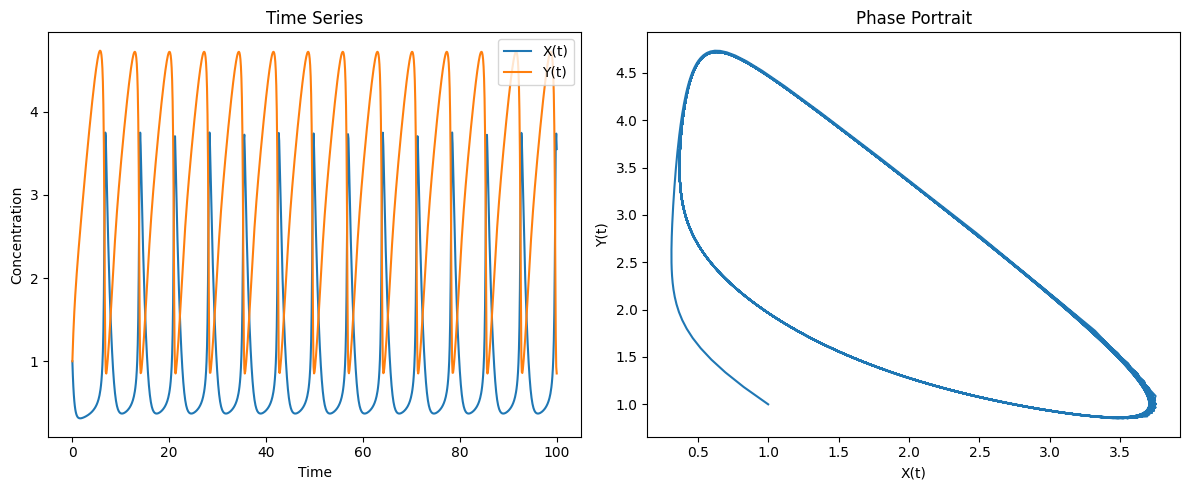

In [11]:
initial_conditions = [1,1] #[X, Y]
parameters = [1, 3, 1, 1]
time = np.linspace(0, 100, 1001)
solution = run_simulation(brusselator_ODE, parameters, initial_conditions, time)
plot_simulation_results(time, solution)

**Stable fixed point**

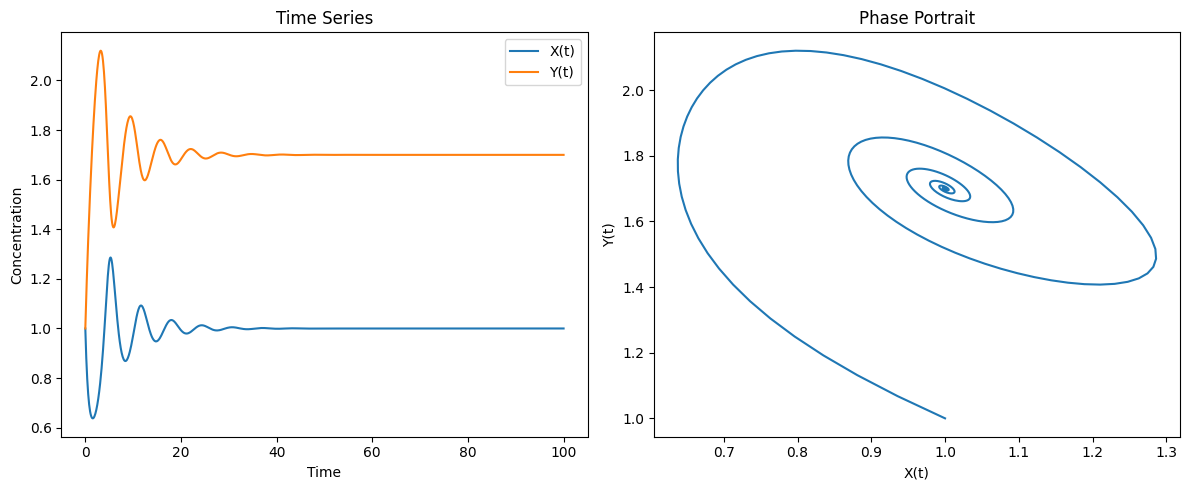

In [12]:
initial_conditions = [1,1] #[X, Y]
parameters = [1, 1.7, 1, 1]
time = np.linspace(0, 100, 1001)
solution = run_simulation(brusselator_ODE, parameters, initial_conditions, time)
plot_simulation_results(time, solution)

### Question 2
Simulate the Brusselator using the Gillespie algorithm code provided below:  

1. Study the Gillespie algorithm code. Explain each step of the algorithm, detailing how it simulates the stochastic time evolution of the Brusselator.

2. Identify the parts of the code annotated with 'FILL HERE' and write the code to complete the simulation.  

3. Run the Gillespie algorithm to simulate the Brusselator process and describe the results. In particular, plot X and Y in function of time as well as the phase portrait X vs. Y (code provided). Compare these stochastic simulation results with those obtained from the deterministic model, discussing any differences or similarities in behavior.   

4. Analyze how varying parameters, especially the system size $\Omega$, influences the behavior of X and Y over time. Discuss how the system size affects the dynamics of the Brusselator?  

5. Investigate how the number of Gillespie steps required to reach a certain time point scales with the system size $\Omega$?  

### Answer 2

1. The algorithm is similar than in **Question 1**, except that we are using the cumulative sum of the rates to select the next reaction (which is equivalent).  

2. See code below.  

3. We see that the stochastic trajectories are converging around the deterministic limit cycle or stable fixed point. However, the behavior may diverge slightly between the two approaches, due to the inherent noise present in the stochastic model. This divergence becomes more noticeable when parameters are set near the bifurcation point between the limit cycle and the stable fixed point.


#### Gillespie simulation of the Brusselator

In [13]:
def run_gillespie(n0, m0, t_end, omega, parameters):
    """
    Simulates the Brusselator process using the Gillespie stochastic simulation algorithm.

    Parameters:
    n0 : Initial count of species n.
    m0 : Initial count of species m.
    t_end : Total simulation time.
    omega : System size parameter, related to volume.
    parameters: k1, k2, k3, k4 reaction rate constants.

    Returns:
    n : Trajectory of species n counts over time.
    m : Trajectory of species m counts over time.
    t : Time points for each recorded state.
    """

    n = [n0]  # Trajectory of species n
    m = [m0]  # Trajectory of species m
    t = [0]   # Time trajectory
    k1, k2, k3, k4 = parameters
    # Stoichiometric matrix S
    S = np.array([[1, 0], [-1, 1], [1, -1], [-1, 0]])

    while t[-1] < t_end:
        current_n = n[-1]
        current_m = m[-1]

        # Calculate reaction rates
        #FILL HERE
        rates = [  
            k1 * omega,
            current_n * k2,
            current_n * (current_n - 1) * current_m * k3 / (omega**2),
            k4*current_n]

        rates_tot = sum(rates)

        # Determine time to next reaction
        dt = np.random.exponential(scale=1.0 / rates_tot)
        t.append(t[-1] + dt)

        # Choose the next reaction
        rand = np.random.random()        
        rates_cumsum = np.cumsum(rates)/rates_tot

        i=0
        while rand >= rates_cumsum[i]:
            i=i+1
        chosen_react=i

        # Update species counts
        n.append(current_n + S[chosen_react, 0])  #FILL HERE
        m.append(current_m + S[chosen_react, 1])

    return n, m, t

def plot_results(t, n, m, results_det, omega):
    """
    Plots the results of the Gillespie simulation for the Brusselator process.

    Parameters:
    t : Time points.
    n : Counts of species N over time.
    m : Counts of species Y over time.
    results_det : Results from the deterministic simulation for comparison.
    omega : System size parameter.
    """
    
    # Plot time series of n(t) and m(t)
    plt.figure(figsize=(12, 5))
    plt.plot(t, n, label='n(t)', color='blue')
    plt.plot(t, m, label='m(t)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Number of molecules')
    plt.title('Time Series')
    plt.legend()
    plt.show()
    
    # Plot phase portrait
    plt.figure(figsize=(10, 10))
    plt.plot(results_det[:, 0], results_det[:, 1], label='Deterministic', color='tomato', alpha=1)
    plt.plot(np.array(n) / omega, np.array(m) / omega, label='Stochastic', color='forestgreen', alpha=0.4, lw=1)
    plt.xlabel('Concentration (X or n/Ω)')
    plt.ylabel('Concentration (Y or m/Ω)')
    plt.title('Phase Portrait')
    plt.legend()
    plt.show()



#### Run Gillespise and plot the trajectory and the phase portrait

**Stable fixed point**

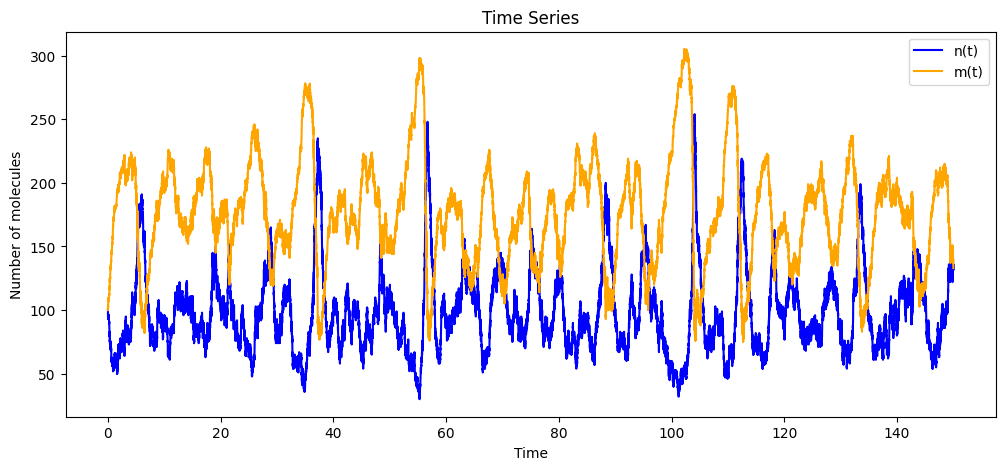

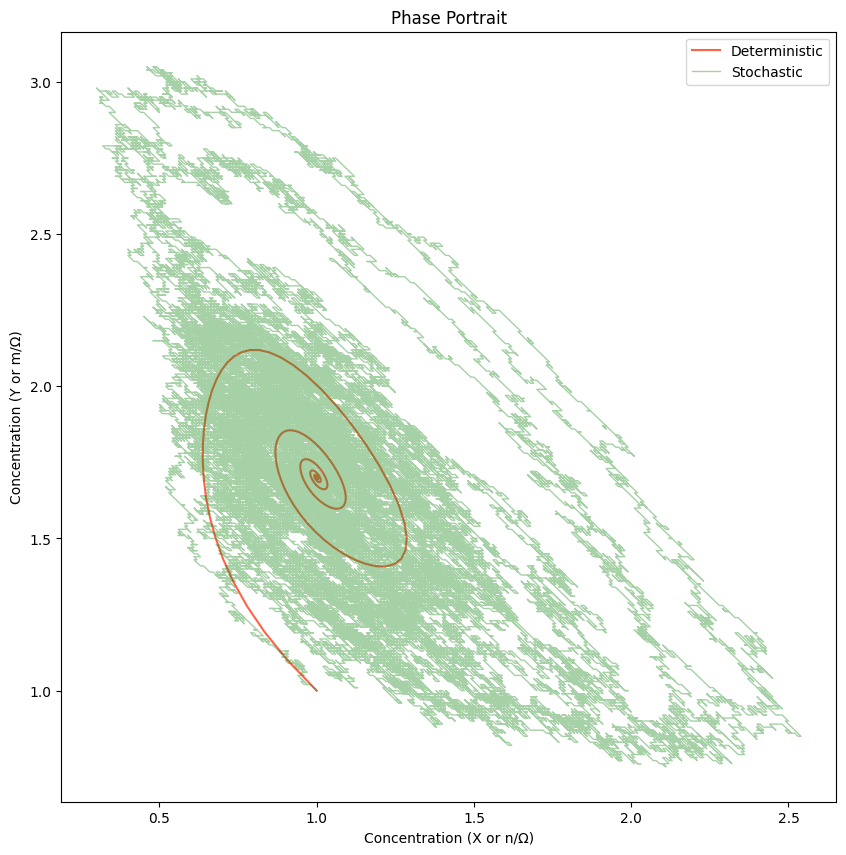

In [14]:
#Define your parameters
k1 = k3 = k4 = 1
k2 = 1.7
omega = 100
t_end = 150
initial_conditions = [1, 1]

#Deterministic
parameters = [k1, k2, k3, k4] #rate constants
time = np.linspace(0, t_end, 1001)
results_det = run_simulation(brusselator_ODE, parameters, initial_conditions, time)

#Stochastic 
[n, m, t] = run_gillespie(initial_conditions[0] * omega, initial_conditions[1] * omega, t_end, omega, parameters)
plot_results(t, n, m, results_det, omega)


**limit cycle**

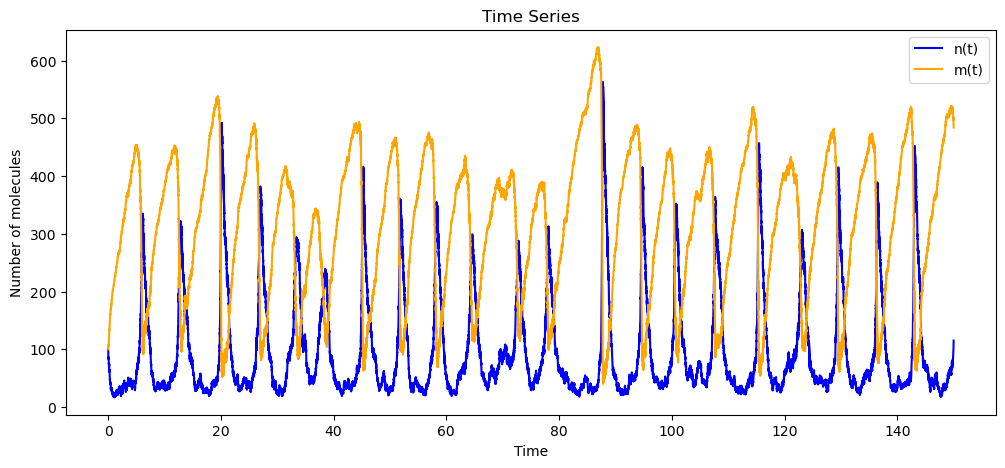

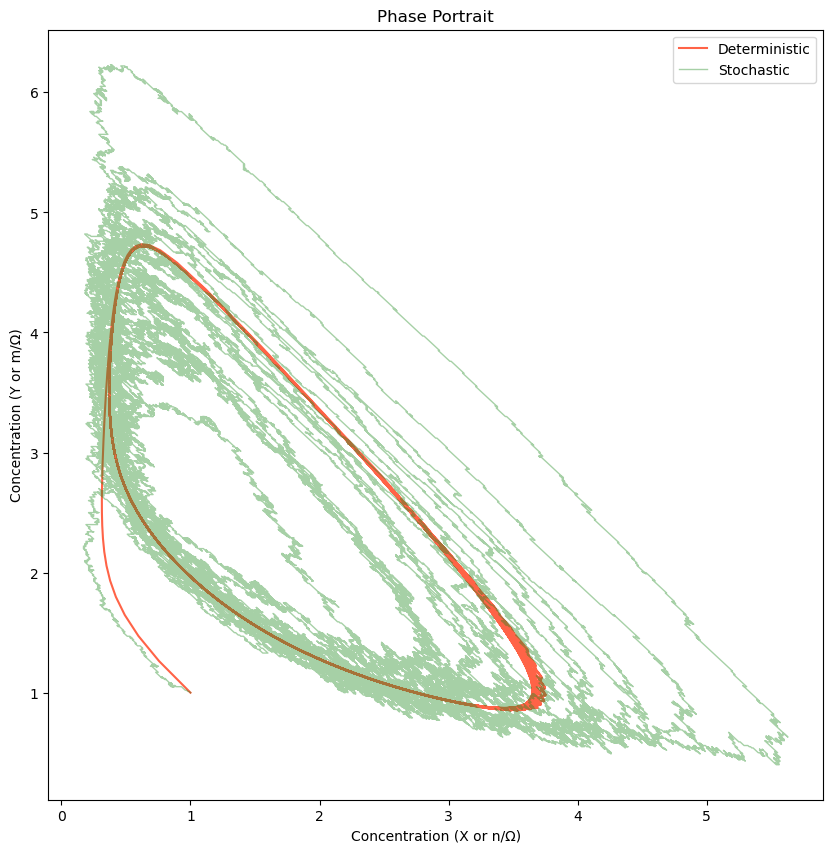

In [54]:
#Define your parameters
k1 = k3 = k4 = 1
k2 = 3
omega = 100
t_end = 150
initial_conditions = [1, 1]

#Deterministic
parameters = [k1, k2, k3, k4] #rate constants
time = np.linspace(0, t_end, 1001)
results_det = run_simulation(brusselator_ODE, parameters, initial_conditions, time)

#Stochastic 
[n, m, t] = run_gillespie(initial_conditions[0] * omega, initial_conditions[1] * omega, t_end, omega, parameters)
plot_results(t, n, m, results_det, omega)

**4.** The system size $\Omega$ tunes the noise within the system. When the system size $\Omega$ is large, it effectively reduces the relative noise.

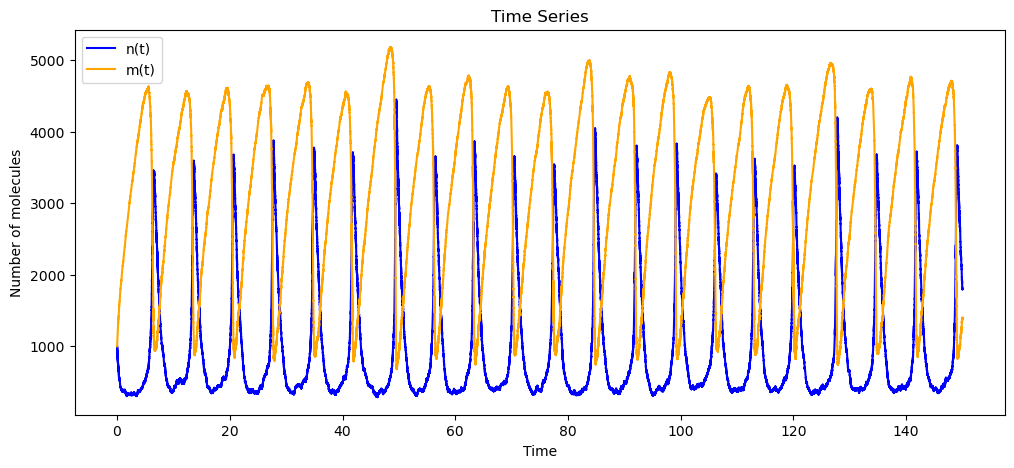

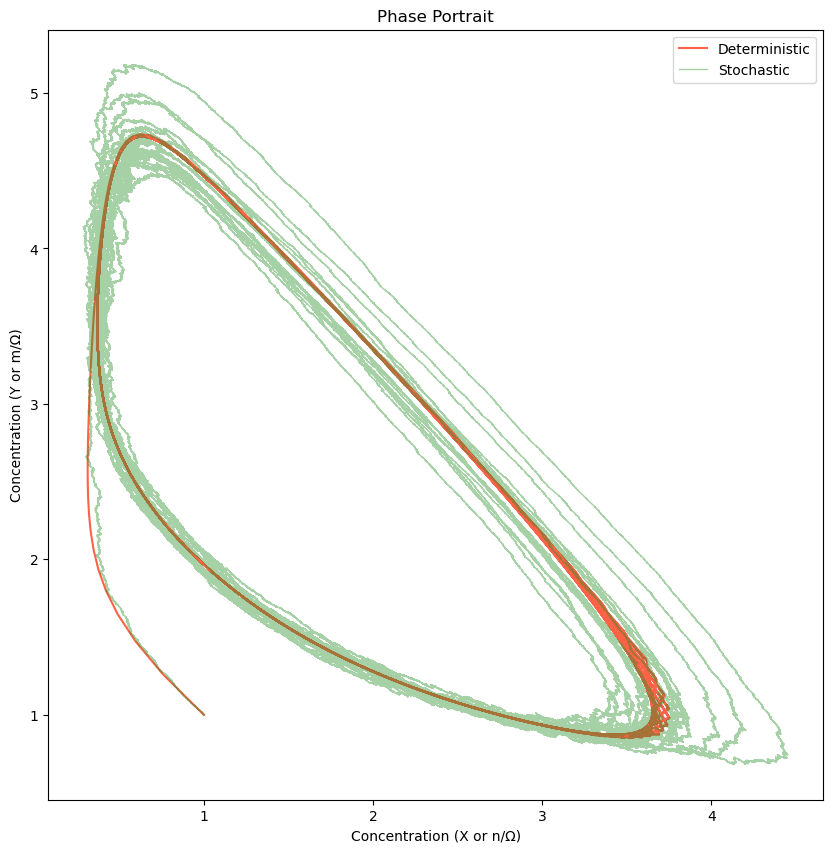

In [55]:
#Define your parameters
k1 = k3 = k4 = 1
k2 = 3
omega = 1000
t_end = 150
initial_conditions = [1, 1]

#Deterministic
parameters = [k1, k2, k3, k4] #rate constants
time = np.linspace(0, t_end, 1001)
results_det = run_simulation(brusselator_ODE, parameters, initial_conditions, time)

#Stochastic 
[n, m, t] = run_gillespie(initial_conditions[0] * omega, initial_conditions[1] * omega, t_end, omega, parameters)
plot_results(t, n, m, results_det, omega)

**5.** Empirically, the running time scales roughly exponentially with the system size $\Omega$.